In [62]:
import dimod
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from collections import Counter
from dwave.system import LeapHybridDQMSampler
from pyqubo import Binary, Array
from sklearn.datasets import make_blobs

In [11]:
N = 30
K = 3

In [12]:
def get_distance(i, j, df, num_colors):
    x = df.iloc[i, :num_colors].to_numpy()
    y = df.iloc[j, :num_colors].to_numpy()
    return np.linalg.norm(x-y)

In [63]:
# Make distance matrix
dist_matrix = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        if i != j:
            dist_matrix[i][j] = get_distance(i, j, df, num_colors=K)

# Print dist matrix
#np.array(dist_matrix)

In [15]:
# generate k clusters, classical way
centers = [[1, 1], [-1, -1], [1, -1]]
sz_per_cluster = N//K
ft_dim = 2
stddev = 0.3
output_name = "tmp"
n_samples = len(centers) * sz_per_cluster
x, labels= make_blobs(
    n_samples=n_samples,
    n_features=ft_dim,
    centers=centers,
    cluster_std=stddev
)

df = pd.DataFrame(x, columns=[f"ft_{i}" for i in range(ft_dim)])
df['label']=labels
# print(df)
# print(df.iloc[2,:2].to_numpy())
df.to_csv(output_name+".csv", index=False)

plt.scatter(x[:,0], x[:,1], c=labels)
plt.savefig(output_name+".png", dpi=300)

In [16]:
# x_{i, j} = point i belongs to cluster j
group_matrix = Array.create('x', shape=(N, K), vartype='BINARY')

In [23]:
distinct_size_penalty = 1
multiple_assignment_penalty = 10

In [24]:
all_terms = []

In [25]:
# Penalty for being assigned to multiple clusters
for i in range(N):
    single_asignment_constraint = (1 - sum(group_matrix[i,:]))**2
    all_terms.append(
        single_asignment_constraint * multiple_assignment_penalty
    )

In [26]:
# Penalty for exceding equal number of members per cluster
for j in range(K):
    target_size = N//K
    cluster_member_constraint = (target_size - sum(group_matrix[:, j]))**2
    all_terms.append(
        multiple_assignment_penalty*cluster_member_constraint
    )

In [27]:
# Adding objective for distances. Must minimize distances in the same group
for i in range(N):
    for j in range(i+1, N):
        same_group_combinations = group_matrix[i,:] * group_matrix[j,:]
        all_terms.append(
            dist_matrix[i,j] * sum(same_group_combinations)
        )


In [32]:
equation = sum(all_terms)
Q = equation.compile().to_qubo()[0]

In [30]:
sampler = LeapHybridSampler()

In [36]:
answer = sampler.sample_qubo(Q)

Sample(sample={'x[0][0]': 1, 'x[0][1]': 0, 'x[0][2]': 0, 'x[10][0]': 1, 'x[10][1]': 0, 'x[10][2]': 0, 'x[11][0]': 0, 'x[11][1]': 1, 'x[11][2]': 0, 'x[12][0]': 0, 'x[12][1]': 0, 'x[12][2]': 1, 'x[13][0]': 1, 'x[13][1]': 0, 'x[13][2]': 0, 'x[14][0]': 0, 'x[14][1]': 0, 'x[14][2]': 1, 'x[15][0]': 1, 'x[15][1]': 0, 'x[15][2]': 0, 'x[16][0]': 0, 'x[16][1]': 0, 'x[16][2]': 1, 'x[17][0]': 1, 'x[17][1]': 0, 'x[17][2]': 0, 'x[18][0]': 1, 'x[18][1]': 0, 'x[18][2]': 0, 'x[19][0]': 0, 'x[19][1]': 1, 'x[19][2]': 0, 'x[1][0]': 0, 'x[1][1]': 1, 'x[1][2]': 0, 'x[20][0]': 0, 'x[20][1]': 0, 'x[20][2]': 1, 'x[21][0]': 0, 'x[21][1]': 1, 'x[21][2]': 0, 'x[22][0]': 1, 'x[22][1]': 0, 'x[22][2]': 0, 'x[23][0]': 0, 'x[23][1]': 1, 'x[23][2]': 0, 'x[24][0]': 1, 'x[24][1]': 0, 'x[24][2]': 0, 'x[25][0]': 0, 'x[25][1]': 0, 'x[25][2]': 1, 'x[26][0]': 0, 'x[26][1]': 0, 'x[26][2]': 1, 'x[27][0]': 0, 'x[27][1]': 1, 'x[27][2]': 0, 'x[28][0]': 0, 'x[28][1]': 1, 'x[28][2]': 0, 'x[29][0]': 0, 'x[29][1]': 0, 'x[29][2]': 1, '

In [43]:
best_answer = list(answer.data(['sample', 'energy']))[0].sample
print(best_answer)

{'x[0][0]': 1, 'x[0][1]': 0, 'x[0][2]': 0, 'x[10][0]': 1, 'x[10][1]': 0, 'x[10][2]': 0, 'x[11][0]': 0, 'x[11][1]': 1, 'x[11][2]': 0, 'x[12][0]': 0, 'x[12][1]': 0, 'x[12][2]': 1, 'x[13][0]': 1, 'x[13][1]': 0, 'x[13][2]': 0, 'x[14][0]': 0, 'x[14][1]': 0, 'x[14][2]': 1, 'x[15][0]': 1, 'x[15][1]': 0, 'x[15][2]': 0, 'x[16][0]': 0, 'x[16][1]': 0, 'x[16][2]': 1, 'x[17][0]': 1, 'x[17][1]': 0, 'x[17][2]': 0, 'x[18][0]': 1, 'x[18][1]': 0, 'x[18][2]': 0, 'x[19][0]': 0, 'x[19][1]': 1, 'x[19][2]': 0, 'x[1][0]': 0, 'x[1][1]': 1, 'x[1][2]': 0, 'x[20][0]': 0, 'x[20][1]': 0, 'x[20][2]': 1, 'x[21][0]': 0, 'x[21][1]': 1, 'x[21][2]': 0, 'x[22][0]': 1, 'x[22][1]': 0, 'x[22][2]': 0, 'x[23][0]': 0, 'x[23][1]': 1, 'x[23][2]': 0, 'x[24][0]': 1, 'x[24][1]': 0, 'x[24][2]': 0, 'x[25][0]': 0, 'x[25][1]': 0, 'x[25][2]': 1, 'x[26][0]': 0, 'x[26][1]': 0, 'x[26][2]': 1, 'x[27][0]': 0, 'x[27][1]': 1, 'x[27][2]': 0, 'x[28][0]': 0, 'x[28][1]': 1, 'x[28][2]': 0, 'x[29][0]': 0, 'x[29][1]': 0, 'x[29][2]': 1, 'x[2][0]': 0, '

In [51]:
cluster_result = [
    k for k, v in best_answer.items() if v == 1
]

processed = [0 for val in cluster_result]

for val in cluster_result:
    _, i, j = val.replace("[", " ").replace("]", " ").split()
    
    processed[int(i)] = int(j)

print(processed)

[0, 1, 1, 2, 0, 0, 1, 2, 1, 2, 0, 1, 2, 0, 2, 0, 2, 0, 0, 1, 2, 1, 0, 1, 0, 2, 2, 1, 1, 2]


In [53]:
sum(processed)/len(processed)

1.0

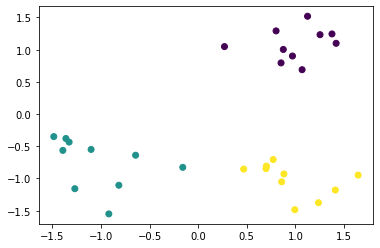

In [60]:
plt.scatter(x[:,0], x[:,1], c=processed)

In [61]:
Counter(processed)  # checking if the counts are the same

Counter({0: 10, 1: 10, 2: 10})